In [1]:
import shutil

import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import networkx as nx
from scipy.spatial.distance import cdist
from combine_gtfs_feeds import cli
from gtfsmerger import GTFSMerger
from pathlib import Path
from zipfile import ZIP_DEFLATED, ZipFile

from os import PathLike
from typing import Union
import os

In [2]:
# Basic geographic setup

In [3]:
from citychef import spatial
from citychef import graph
from citychef import household as hh
from citychef import tree
from citychef import osm
from citychef import gtfs

In [4]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [5]:
city_dir = "./sample_setup"

if not os.path.exists(city_dir):
    os.mkdir(city_dir)
else:
    print("WARNING - potentially overwritting previous results")

WARNING - potentially overwritting previous results


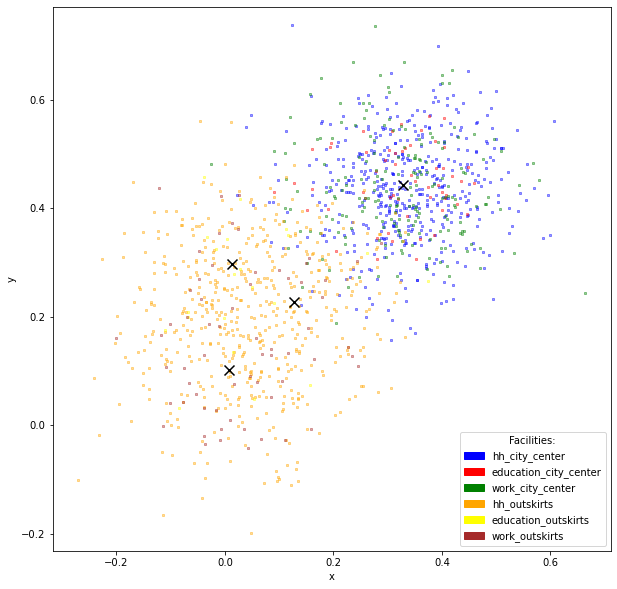

In [6]:
central_city_bbox = np.array([[0.3,0.3],[0.5,0.5]])  # min x, min y, max x, max y (DEGREES)
outskirts_bbox = np.array([[0,0],[0.3,0.3]])
combined_bbox = np.array([[0,0],[0.5,0.5]])
city_center = spatial.Centres(central_city_bbox, number=1)
outskirts = spatial.Centres(outskirts_bbox, number=3)

class CombinedCenters(spatial.Centres):

    def __init__(self, combined_bbox, *args):
        super().__init__(combined_bbox)
        self.num = args[0].size
        self.locs = args[0].locs

        for centers in args[1:]:
            self.num += centers.size
            self.locs = np.vstack([self.locs, centers.locs])

combined = CombinedCenters(combined_bbox, city_center, outskirts)

facilities = {
    'hh_city_center': spatial.Clusters(city_center, size=500, sigma=.1),
    'education_city_center': spatial.Clusters(city_center, size=50, sigma=.08),
    'work_city_center': spatial.Clusters(city_center, size=200, sigma=.1),
    'hh_outskirts': spatial.Clusters(outskirts, size=500, sigma=.1),
    'education_outskirts': spatial.Clusters(outskirts, size=20, sigma=.1),
    'work_outskirts': spatial.Clusters(outskirts, size=50, sigma=.09),
}
bbox = spatial.collect_bbox(facilities) # adjust the bbox for max extends
spatial.plot_facilities(facilities, combined)

0.014610168995005529


(-0.23697082509861633,
 0.7176576170350454,
 -0.1647401449008714,
 0.7912863415818231)

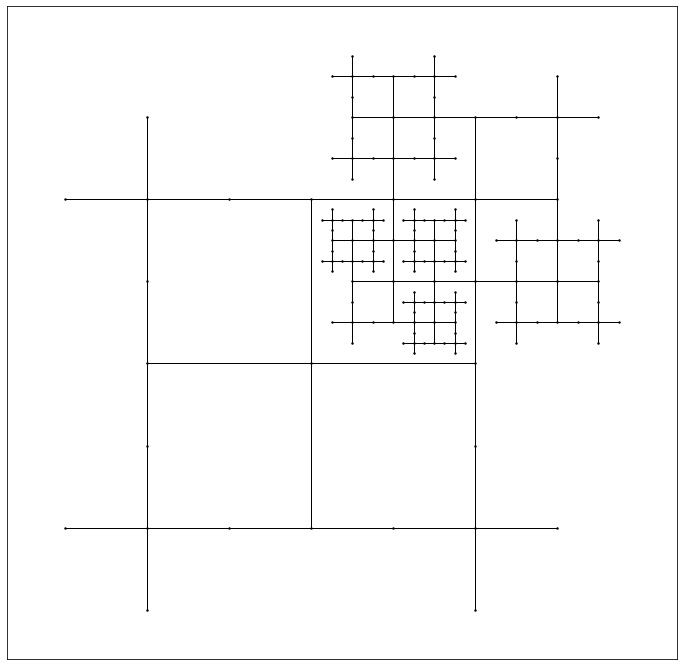

In [7]:
car_network = graph.TreeNetwork(
    bbox, facilities['hh_city_center'], grid='regular', max_points=40
)
print(car_network.min_link_length)
car_network.plot()
plt.axis('equal')

In [8]:
buses = graph.Transit(car_network, facilities['education_outskirts'], density_radius=.1)
buses.build_routes(num_routes=8, max_length=30, min_length=11, straightness=5)
print(buses.min_link_length)

0.014610168995005529


(-0.23697082509861633,
 0.7176576170350454,
 -0.1647401449008714,
 0.7912863415818231)

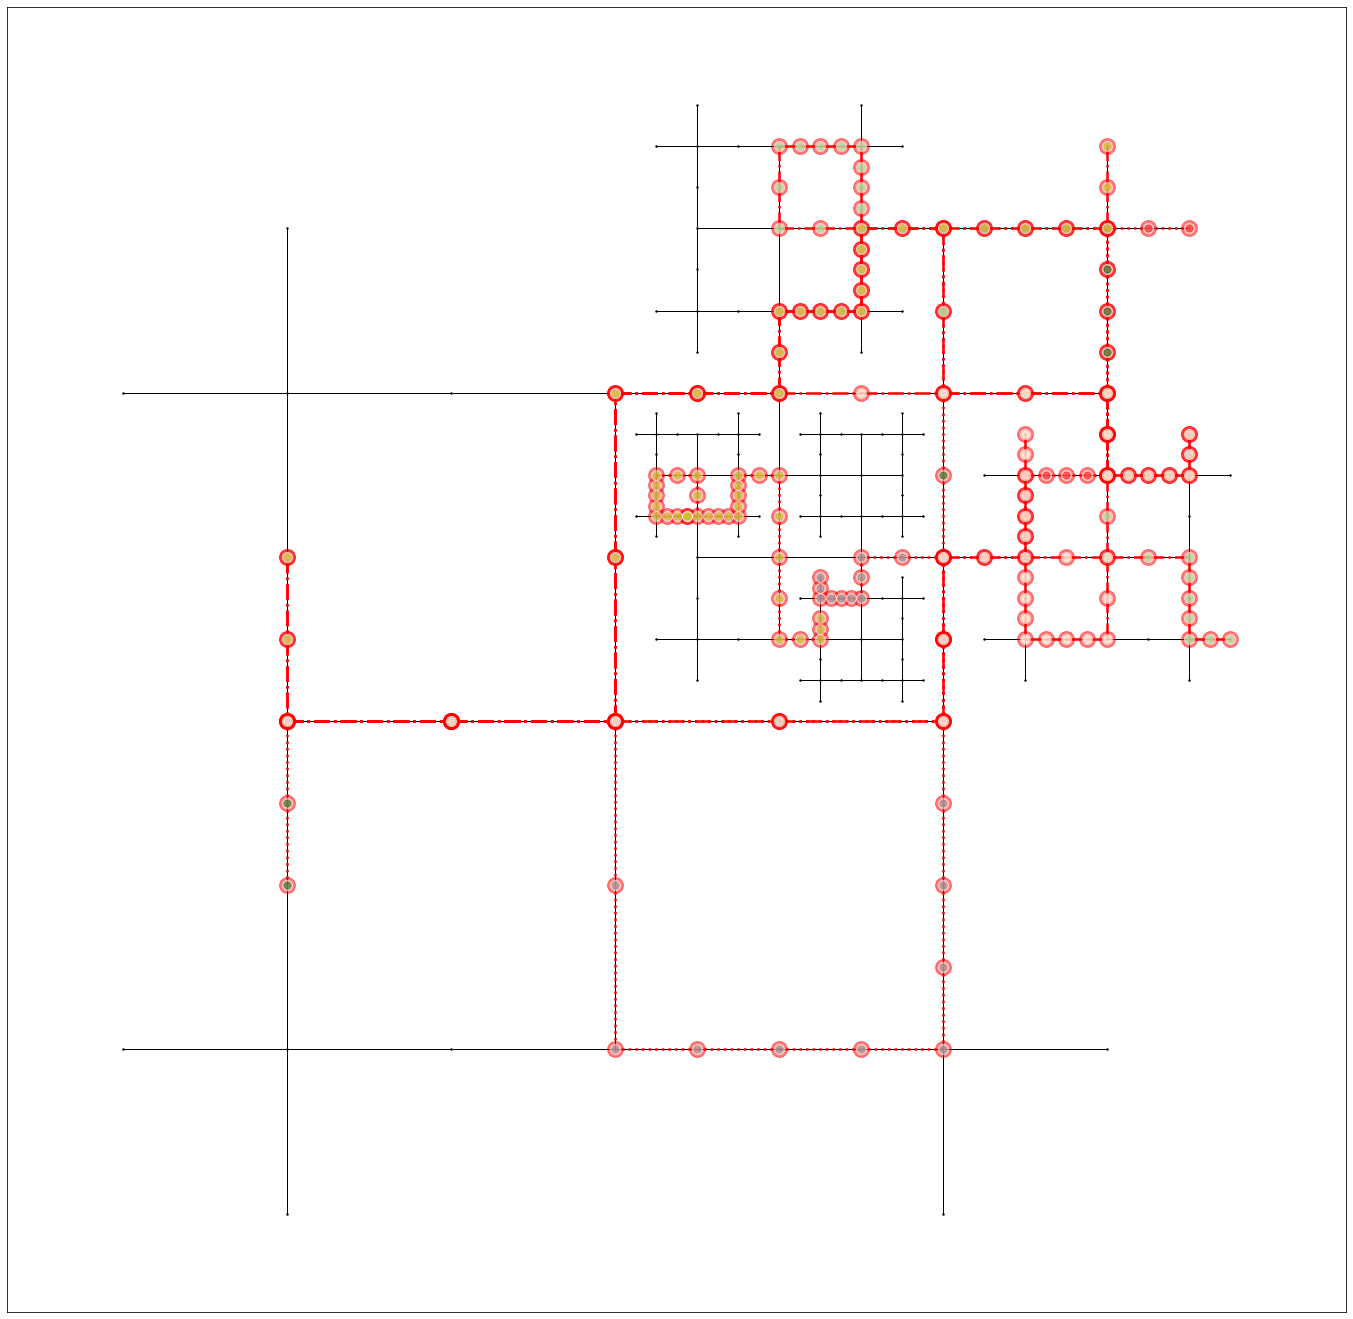

In [9]:
buses.interpolate_routes()
buses.jitter_locations(1e-08)
fig, ax = plt.subplots(1, 1, figsize=(24, 24))
car_network.plot(ax=ax)
buses.plot(ax=ax)
plt.axis('equal')

In [10]:
# check min and max distances
print(buses.min_link_length * 111139)
print(buses.max_link_length * 111139) # approx conv to m

811.8797859679597
19504.138707847775


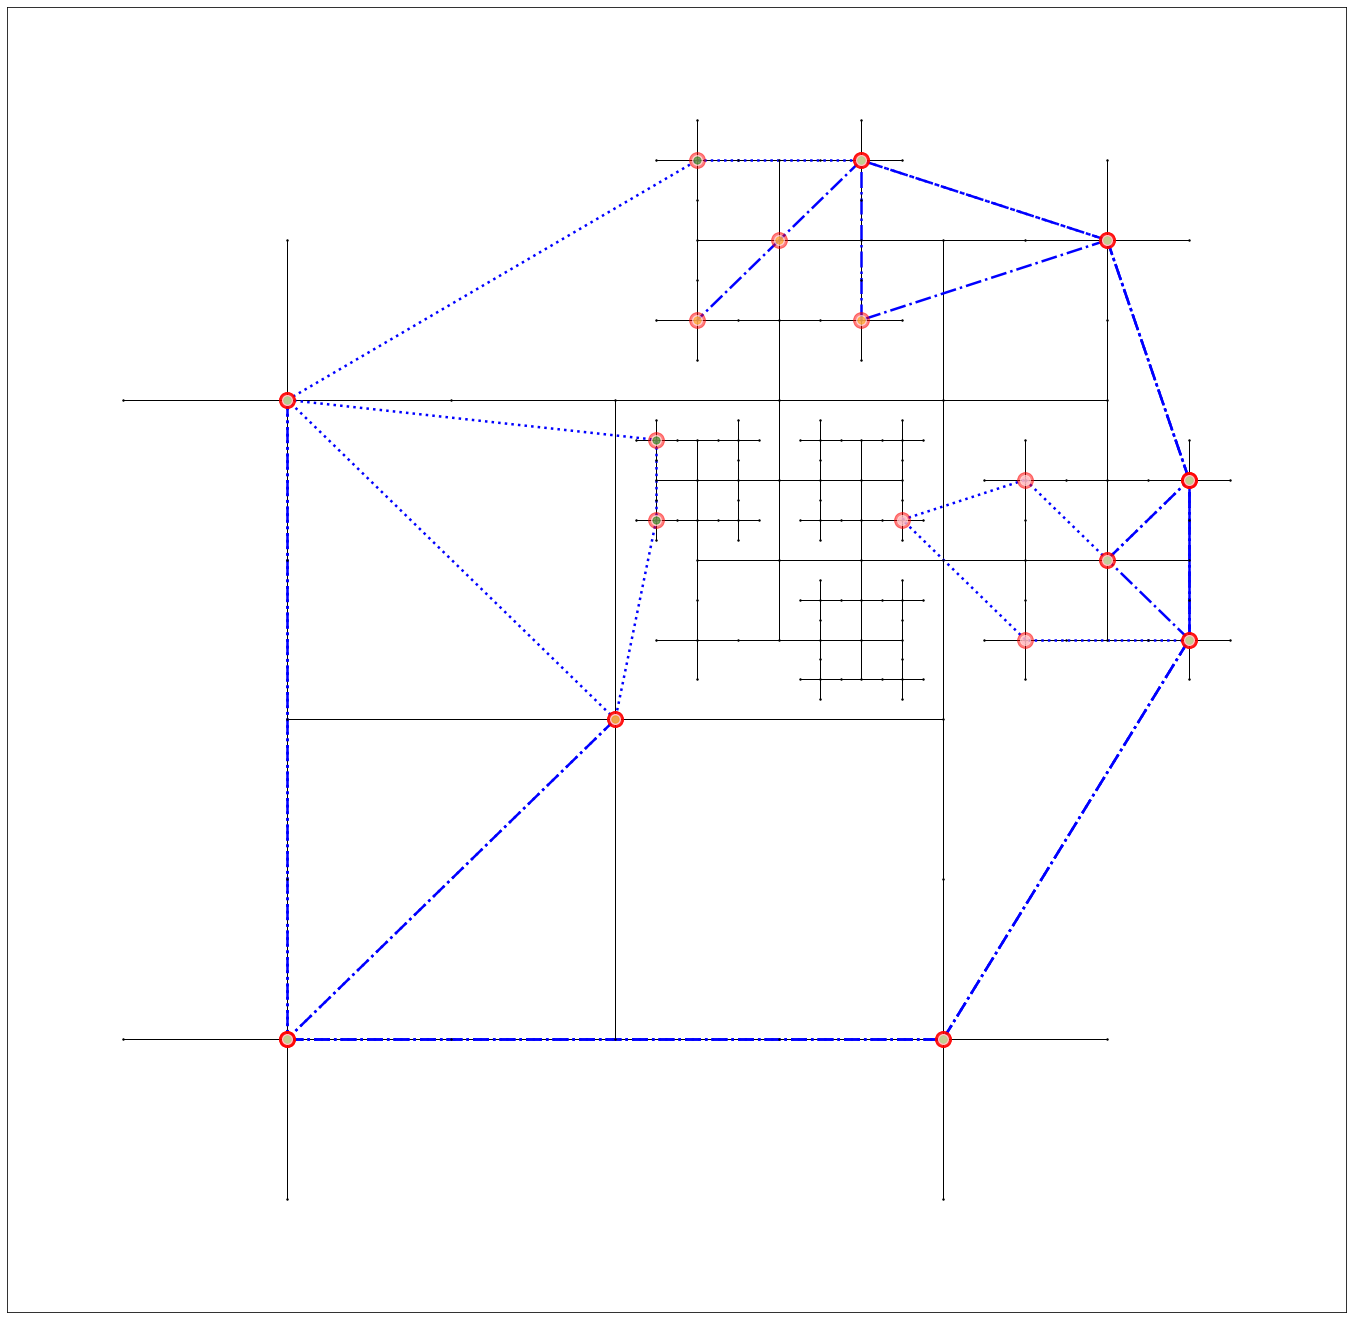

In [11]:
# first we extract potential locations for stations, we force stations to match vertices
# from the road ntwork, eg :
potential_stations = np.array([v['pos'] for k, v in car_network.g.nodes.items() if k[:2] == '00'])
rail_network = graph.DelaunayNetwork(potential_stations)

trains = graph.Transit(rail_network, facilities['hh_outskirts'], density_radius=0.1)
train_routes = trains.build_routes(num_routes=4, max_length=10, min_length=5, straightness=50)

fig, ax = plt.subplots(1, 1, figsize=(24, 24))
car_network.plot(ax=ax)
trains.plot(ax=ax, line_colour='blue')

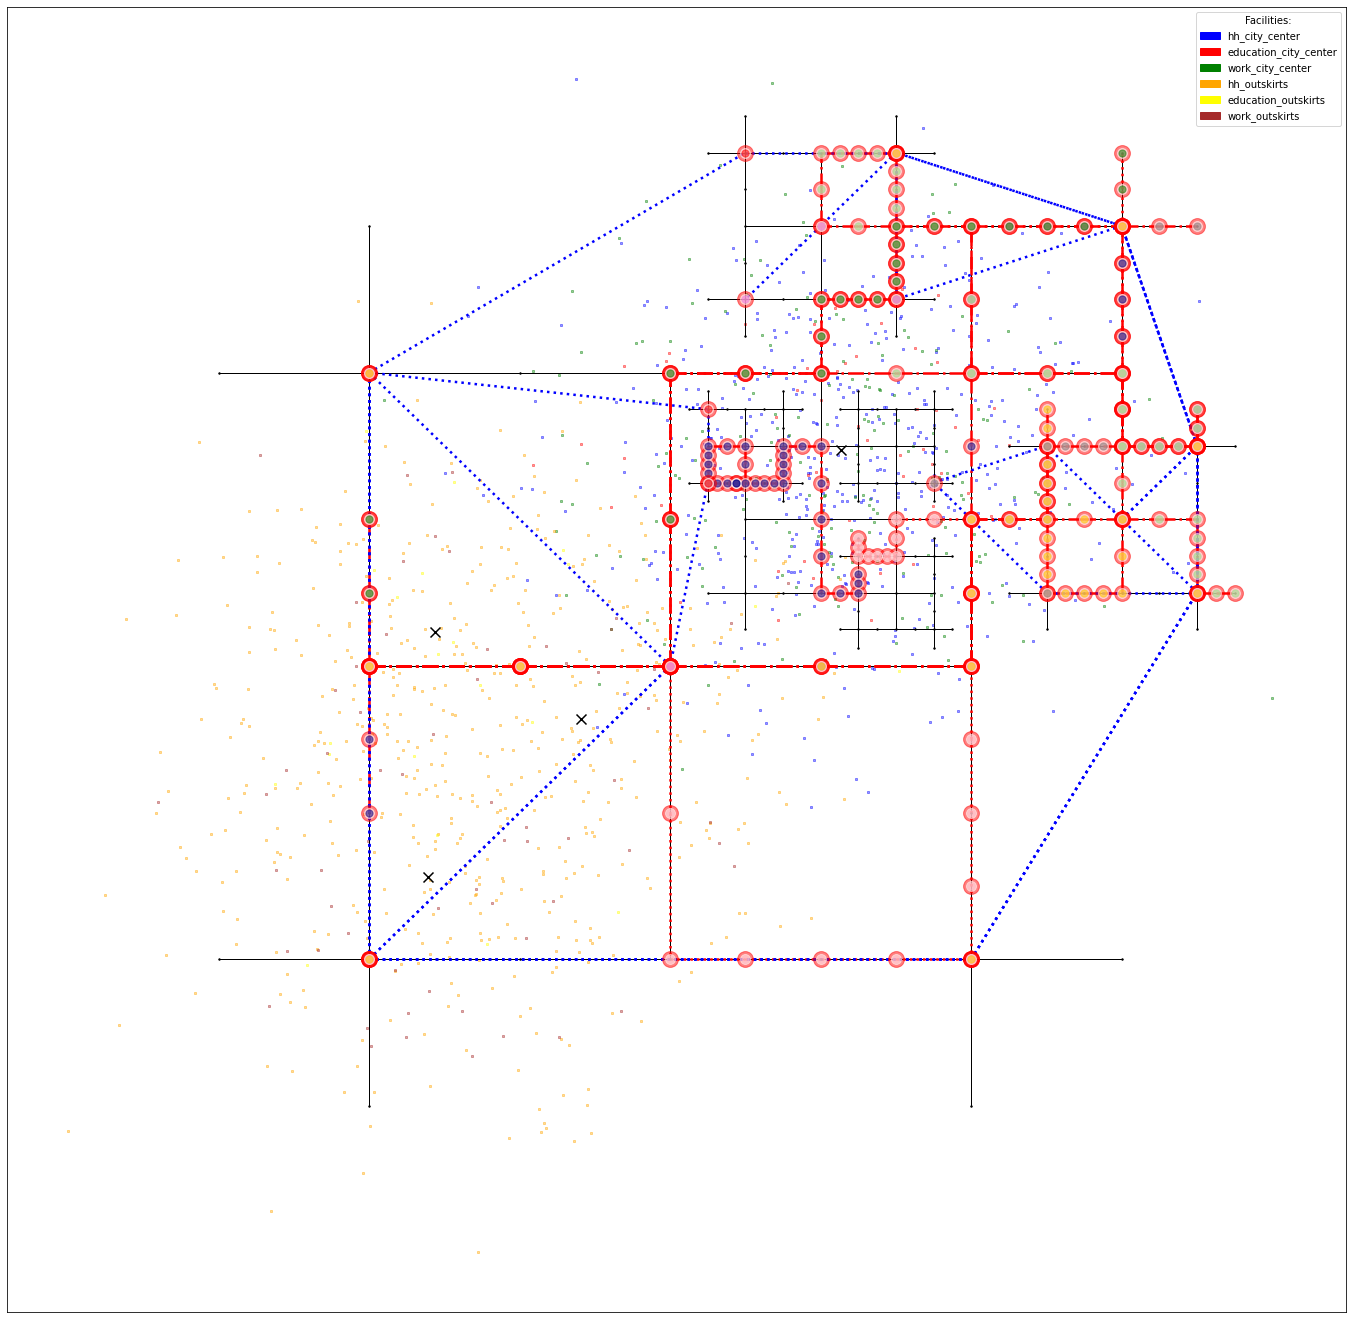

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(24, 24))
spatial.plot_facilities(facilities, centres=combined, ax=ax)
car_network.plot(ax=ax)
buses.plot(ax=ax)
trains.plot(ax=ax, line_colour='blue')
fig.patch.set_visible(False)
# ax.axis('off')
# plt.axis('equal')

# Creating Files

In [13]:
osm.nx_to_osm(
    g=car_network.g,
    path=os.path.join(city_dir, "osm.xml")
)

Output()

In [ ]:
"""
Converts a file from one format to another.
This example shows how to write objects to a file.
From: https://github.com/osmcode/pyosmium/blob/master/examples/convert.py
"""

import osmium as o

class Convert(o.SimpleHandler):

    def __init__(self, writer):
        super(Convert, self).__init__()
        self.writer = writer

    def node(self, n):
        self.writer.add_node(n)

    def way(self, w):
        self.writer.add_way(w)

    def relation(self, r):
        self.writer.add_relation(r)

In [15]:
in_file = os.path.join(city_dir, "osm.xml")
out_file = os.path.join(city_dir, "osm.pbf")

if not os.path.exists(in_file):
    raise RuntimeError('need to run GTFS generation first')
if os.path.exists(out_file):
    print(f"Deleting old {in_file}")
    os.remove(out_file)

writer = o.SimpleWriter(out_file)
handler = Convert(writer)

handler.apply_file(in_file)
writer.close()

os.remove(in_file)

Deleting old ./sample_setup/osm.xml


In [16]:
def zip_dir(zip_name: PathLike, source_dir: Union[str, PathLike]):
    src_path = Path(source_dir).expanduser().resolve(strict=True)
    with ZipFile(zip_name, 'w', ZIP_DEFLATED) as zf:
        for file in src_path.rglob('*'):
            zf.write(file, file.relative_to(src_path))

In [17]:
gtfs.build_gtfs(
    name="buses",
    transit=buses,
    out_dir=city_dir,
    agency_id=0,
    route_type=3,
    frequency=10,
    agency_name='test_city_buses'
)
zip_dir(os.path.join(city_dir, 'gtfs_buses.zip'), os.path.join(city_dir, 'gtfs_buses'))

Output()

In [18]:
gtfs.build_gtfs(
    name="trains",
    transit=trains,
    out_dir=city_dir,
    agency_id=1,
    route_type=2,
    frequency=15,
    agency_name='test_city_trains',
)
zip_dir(os.path.join(city_dir, 'gtfs_trains.zip'), os.path.join(city_dir, 'gtfs_trains'))

Output()

In [19]:
gtfs_merger = GTFSMerger()
f_1 = open(os.path.join(city_dir, 'gtfs_buses.zip'), 'rb').read()
f_2 = open(os.path.join(city_dir, 'gtfs_trains.zip'), 'rb').read()
gtfs_merger.merge_from_bytes_list([f_1, f_2])
gtfs_merger.get_zipfile(os.path.join(city_dir, 'gtfs.zip'))

# Deleting unnecessary files
# os.remove(os.path.join(city_dir, 'gtfs_buses.zip'))
# os.remove(os.path.join(city_dir, 'gtfs_trains.zip'))
# shutil.rmtree(os.path.join(city_dir, 'gtfs_buses'))
# shutil.rmtree(os.path.join(city_dir, 'gtfs_trains'))

<zipfile.ZipFile [closed]>

In [20]:
facility_points = pd.DataFrame(columns=['facility_type', 'lat', 'lon'])
for facility in facilities:
    for point in facilities[facility].points:
        entry = {
            'facility_type': facility,
            'lon': point.x,
            'lat': point.y
        }
        facility_points = pd.concat([facility_points, pd.DataFrame(entry, index=[0])], ignore_index=True, verify_integrity=True)

In [ ]:
# Store the facilities in separate files
for facility in facilities:
    general_facility = facility.split('_')[0]
    to_save = facility_points[facility_points['facility_type'].str.contains(general_facility)]
    to_save = to_save.drop(columns='facility_type')
    to_save.to_csv(os.path.join(city_dir, f'{general_facility}_points.csv'), index_label='id')